# Front Matter: CASA0013: Foundations of Spatial Data Science

## Title of briefing: The impact of geographical locations, property types and landlord situations on Airbnb house prices in London

### Student ID: 21058831

### Word Count: 1643

# Reproducible Analysis

Please feel free to add as many code cells and markdown cells of comment/explanation as needed to make your code legible and clear. Your code should output any figures needed to disk.

In [91]:
import matplotlib.pyplot as plt
import statsmodels.api as sms
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import csv

import json
import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import seaborn as sns

In [92]:
# Set download URL
url = 'https://github.com/jreades/i2p/raw/master/data/src/2020-08-24-listings.csv.gz?raw=true'

# your code here
import pandas as pd
df = pd.read_csv(url, compression='gzip', low_memory=False)

print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 74,188 x 74


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74188 entries, 0 to 74187
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            74186 non-null  float64
 1   listing_url                                   74187 non-null  object 
 2   scrape_id                                     74187 non-null  object 
 3   last_scraped                                  74187 non-null  object 
 4   name                                          74167 non-null  object 
 5   description                                   71329 non-null  object 
 6   neighborhood_overview                         47208 non-null  object 
 7   picture_url                                   74188 non-null  object 
 8   host_id                                       74188 non-null  float64
 9   host_url                                      74188 non-null 

In [94]:
import os
path = os.path.join('data','raw') # A default location to save raw data
fn   = url.split('/')[-1]         # What does this do?
print(f"Writing to: {fn}")

Writing to: 2020-08-24-listings.csv.gz?raw=true


In [95]:
if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
df.to_csv(os.path.join(path,fn), index=False)
print("Done.")

Done.


In [96]:
cols = ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 'host_since', 
        'host_location', 'host_about', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
        'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 
        'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 
        'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 
        'first_review', 'last_review', 'review_scores_rating', 'review_scores_cleanliness', 
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'license', 
        'instant_bookable', 'calculated_host_listings_count', 'reviews_per_month',       
       'host_neighbourhood','host_has_profile_pic','host_identity_verified','neighbourhood','neighbourhood_cleansed', 'review_scores_accuracy']

In [97]:
del(df)
df = pd.read_csv(os.path.join(path,fn), low_memory=False, usecols=cols, nrows=10000)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 10,000 x 48


# Clean NaN Values

In [98]:
#clean nan values

df[df.id.isna()][['id','listing_url','name','description','host_id','host_name']]

,id,listing_url,name,description,host_id,host_name
3559,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/1c171...,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern..."


In [99]:
df.drop(df[df.id.isna()].index.values, axis=0, inplace=True)
df.isnull().sum(axis=0).sort_values(ascending=False)[:12]
df.drop(columns=['bathrooms','license','host_response_rate','host_acceptance_rate','host_about'], inplace=True)
df.isnull().sum(axis=1).sort_values(ascending=False)

3558    34
8015    19
8052    19
6453    19
8992    19
        ..
4208     0
4207     0
4204     0
4203     0
9999     0
Length: 9999, dtype: int64

<class 'pandas.core.series.Series'>
Have reduced data frame to: 8174 rows and 43 columns


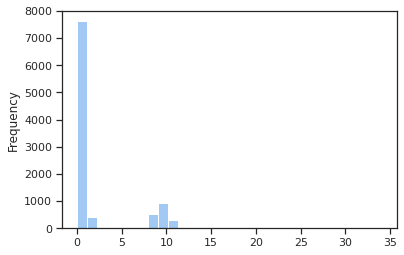

In [100]:
probs = df.isnull().sum(axis=1)
print(type(probs))       
probs.plot.hist(bins=30) 
df.drop(probs[probs > 7].index, inplace=True)
print(f"Have reduced data frame to: {df.shape[0]} rows and {df.shape[1]} columns")

# Categories

In [101]:
#Categories
cats = ['property_type','room_type']
df[cats[0]].value_counts()

Entire apartment                      3455
Private room in apartment             1935
Private room in house                 1258
Entire house                           575
Private room in townhouse              301
Entire townhouse                       162
Entire loft                             79
Private room in bed and breakfast       65
Private room in loft                    51
Entire condominium                      44
Private room in condominium             43
Entire serviced apartment               19
Entire guest suite                      19
Room in serviced apartment              19
Private room in guest suite             17
Shared room in apartment                17
Room in boutique hotel                  16
Private room                            13
Entire guesthouse                       10
Shared room in house                     8
Private room in guesthouse               8
Room in bed and breakfast                7
Shared room in bed and breakfast         6
Boat       

In [102]:
df[cats[1]].value_counts()

Entire home/apt    4385
Private room       3721
Shared room          40
Hotel room           28
Name: room_type, dtype: int64

In [103]:
for c in cats:
    print(f"Converting {c}")
    df[c] = df[c].astype('category')

Converting property_type
Converting room_type


In [104]:
print(df[cats[1]].cat.categories.values)

['Entire home/apt' 'Hotel room' 'Private room' 'Shared room']


## Handle Price Column

In [105]:
money = ['price']
for m in money:
    print(f"Converting {m}")
    df[m] = df[m].str.replace('$','').str.replace(',','').astype('float')

Converting price


/tmp/ipykernel_315/3764303797.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[m] = df[m].str.replace('$','').str.replace(',','').astype('float')


# Dealing with Value

In [106]:
df['bedrooms'] = df['bedrooms'].astype(float)
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates',
         'minimum_nights','maximum_nights','availability_365','calculated_host_listings_count']
for i in ints:
    print(f"Converting {i}")
    try:
        df[i] = df[i].astype('float').astype('int')
    except ValueError as e:
        print("\tConverting to unsigned 16-bit integer.")
        df[i] = df[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
Converting host_total_listings_count
Converting accommodates
Converting minimum_nights
Converting maximum_nights
Converting availability_365
Converting calculated_host_listings_count


In [107]:
df.beds.isna().value_counts()

False    8169
True        5
Name: beds, dtype: int64

# Check the Data After Cleaning

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8174 entries, 0 to 9999
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              8174 non-null   int64   
 1   listing_url                     8174 non-null   object  
 2   last_scraped                    8174 non-null   object  
 3   name                            8173 non-null   object  
 4   description                     8169 non-null   object  
 5   host_id                         8174 non-null   int64   
 6   host_name                       8174 non-null   object  
 7   host_since                      8174 non-null   object  
 8   host_location                   8174 non-null   object  
 9   host_is_superhost               8174 non-null   object  
 10  host_neighbourhood              6829 non-null   object  
 11  host_listings_count             8174 non-null   int64   
 12  host_total_listings_

In [109]:
df.describe()

,id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,...,maximum_nights,availability_365,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,calculated_host_listings_count,reviews_per_month
count,8.174000e+03,8.174000e+03,8174.000000,8174.000000,8174.000000,8174.000000,8174.000000,7978.000000,8169.000000,8174.000000,...,8.174000e+03,8174.000000,8085.000000,8070.000000,8071.000000,8066.000000,8074.000000,8070.000000,8174.000000,8174.000000
mean,4.141184e+06,1.402304e+07,4.196110,4.196110,51.511346,-0.128868,3.019697,1.449862,1.669482,99.080448,...,1.872139e+05,153.942623,93.680396,9.601115,9.327221,9.754029,9.786599,9.504337,3.685588,0.687941
std,2.556472e+06,1.460853e+07,27.142478,27.142478,0.045439,0.085374,1.889192,0.822192,1.278715,115.867067,...,1.249097e+07,154.463262,7.212219,0.746371,0.978506,0.611523,0.582510,0.730965,19.005914,0.953727
min,1.155100e+04,6.821000e+03,0.000000,0.000000,51.297330,-0.479620,1.000000,1.000000,0.000000,12.000000,...,1.000000e+00,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.010000
25%,1.723411e+06,2.988015e+06,1.000000,1.000000,51.483043,-0.189815,2.000000,1.000000,1.000000,45.000000,...,4.000000e+01,0.000000,91.000000,9.000000,9.000000,10.000000,10.000000,9.000000,1.000000,0.100000
50%,4.211565e+06,9.489420e+06,1.000000,1.000000,51.516670,-0.120570,2.000000,1.000000,1.000000,75.000000,...,1.125000e+03,90.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.340000
75%,6.511497e+06,2.223392e+07,2.000000,2.000000,51.542088,-0.071495,4.000000,2.000000,2.000000,120.000000,...,1.125000e+03,340.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,0.880000
max,8.333186e+06,3.040751e+08,1111.000000,1111.000000,51.671870,0.238150,16.000000,8.000000,16.000000,3324.000000,...,1.000000e+09,365.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,718.000000,15.170000


# Select Room Type 

In [110]:
df.groupby('room_type')['property_type'].value_counts()

room_type                                         
Entire home/apt  Entire apartment                     3455
                 Entire house                          575
                 Entire townhouse                      162
                 Entire loft                            79
                 Entire condominium                     44
                                                      ... 
Shared room      Private room in apartment               0
                 Private room in bed and breakfast       0
                 Private room in boat                    0
                 Private room in bungalow                0
                 Yurt                                    0
Name: property_type, Length: 188, dtype: int64

In [111]:
pricey = df[(df.room_type=='Entire home/apt') & (df.price>100)]
print(f"Selected {pricey.shape[0]} rows")

Selected 2394 rows


# Deriving a New Variable

In [112]:
df['z'] = (df.price - df.price.mean()) / df.price.std()
df.z.describe()

count    8.174000e+03
mean     5.563339e-17
std      1.000000e+00
min     -7.515548e-01
25%     -4.667456e-01
50%     -2.078282e-01
75%      1.805479e-01
max      2.783293e+01
Name: z, dtype: float64

In [113]:
df['iqs'] = (df.price - df.price.quantile(0.25))/(df.price.quantile(0.75)-df.price.quantile(0.25))
df.iqs.describe()

count    8174.000000
mean        0.721073
std         1.544894
min        -0.440000
25%         0.000000
50%         0.400000
75%         1.000000
max        43.720000
Name: iqs, dtype: float64

In [114]:
df['lnprice'] = np.log(df.price)
df.lnprice.describe()

count    8174.000000
mean        4.325835
std         0.690342
min         2.484907
25%         3.806662
50%         4.317488
75%         4.787492
max         8.108924
Name: lnprice, dtype: float64

# Visualisation of Price by Simple Statistic

In [115]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")
        
        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
        
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

<AxesSubplot:>

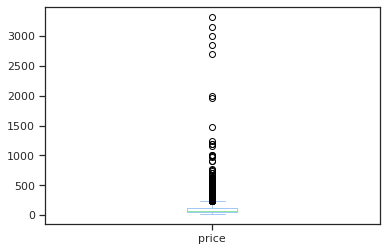

In [116]:
df.price.plot.box()

<AxesSubplot:>

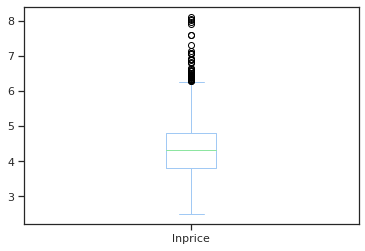

In [117]:
#directly useing price is hard to observe
#let's do log transformation to observe
df.lnprice.plot.box()

# Visualisation of Price by Mapping

In [118]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))

In [119]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))

In [120]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))

In [121]:
print(type(gdf))
print(type(gdf.geometry))
print(gdf.geometry.iloc[1])
gdf.geometry.iloc[1]
print(f"gdf contains {gdf.shape[0]} rows.")

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>
POINT (-0.1112099999999999 51.56802)
gdf contains 8174 rows.


In [122]:
print(f"The range of price is ${gdf.price.min():,.2f} to ${gdf.price.max():,.2f}")
print(f"The mean and median of the price are ${gdf.price.mean():,.2f} and ${gdf.price.median():,.2f}")

The range of price is $12.00 to $3,324.00
The mean and median of the price are $99.08 and $75.00


<AxesSubplot:>

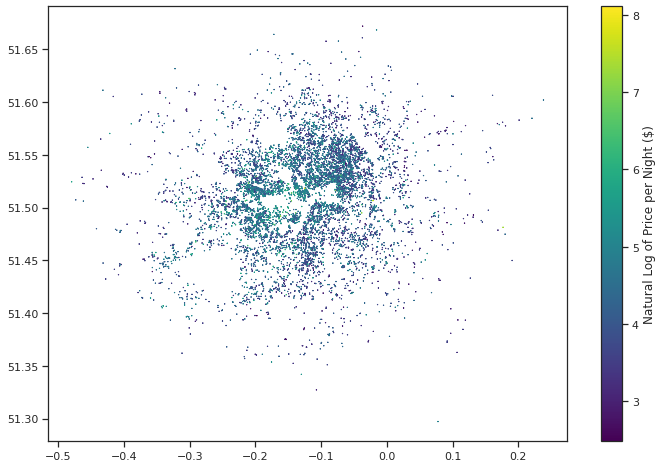

In [123]:
gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', 
         legend=True, legend_kwds={'label':'Natural Log of Price per Night ($)'})

In [124]:
ddir  = os.path.join('data','geo') # destination directory (in case it is not found this directory is created)
spath = 'https://github.com/LeeyuenDong/CASA0013Assessment/blob/main/' # source path

boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )

print('Done.')

Found data/geo/Boroughs.gpkg locally!
Done.


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [125]:
boros.to_file('test.gpkg') # This won't do what we want
boros.to_file('test.gpkg', driver='GPKG')

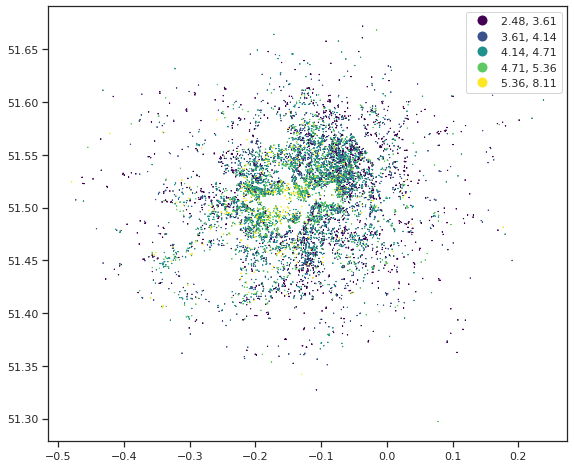

In [126]:
ax = gdf.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis', scheme='fisher_jenks', k=5, 
         legend=True) # Note that the legend label had to go -- there are other ways to add it

epsg:4326
[-0.47962 51.29733  0.23815 51.67187]


<AxesSubplot:>

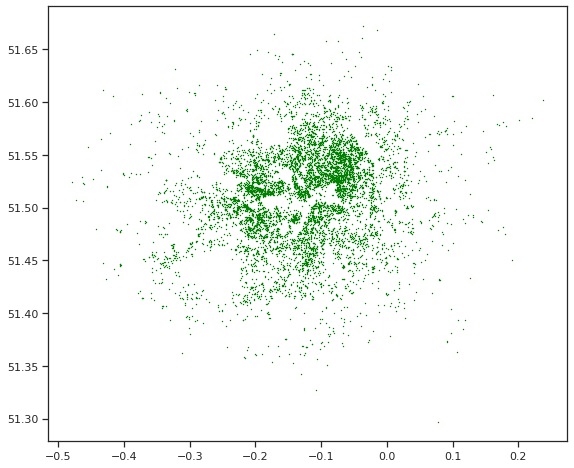

In [127]:
print(gdf.geometry.crs)
print(gdf.total_bounds)
gdf.plot(figsize=(12,8), marker='*', color='green', markersize=0.25)

epsg:27700
[505574.1932404  157405.3783776  555101.5087066  198834.91953868]


<AxesSubplot:>

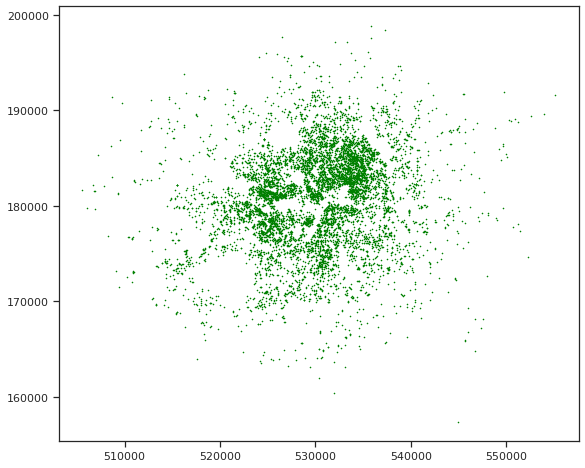

In [128]:
gdf = gdf.to_crs("epsg:27700")
print(gdf.geometry.crs)
print(gdf.total_bounds)
gdf.plot(figsize=(12,8), marker='*', color='green', markersize=0.5)

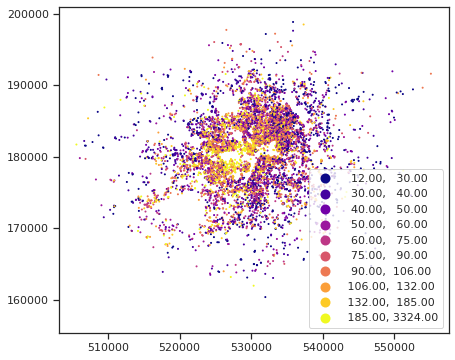

In [129]:
gdf.plot(column='price', cmap='plasma', scheme='quantiles', k=10, markersize=1,legend=True, figsize=(8,6));

In [130]:
#London boroughs

import legendgram
import pysal as p
import mapclassify as mc
import palettable.matplotlib as palmpl
from legendgram import legendgram
def LondonMap():
    
    q = mc.Quantiles(gdf.price.values, k=5) # For Fisher Jenks you may want 'Sampled' to speed things up

    f,ax = plt.subplots(figsize=(15,9))
    gdf.plot(column='lnprice', scheme='Quantiles', k=5, 
         cmap='viridis', legend=True, marker='*', markersize=0.5, ax=ax)
    boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)

    ax.set_xlim([485000,580000])
    ax.set_ylim([150000,206000])
    ax.axis('off') #don't plot the axes (bounding box)
    ax.set_title('London Airbnb Listings Price Per Night', fontdict={'fontsize':'20', 'fontweight':'3'})  #provide a title
    a = ax.annotate('Source: InsideAirbnb (2020)',
             xy=(0.905, 0.055), xycoords='figure fraction', 
             horizontalalignment='right', verticalalignment='bottom', 
             fontsize=12, fontweight=4, color='#555555')  #add source info on the image itself
    a.set_bbox(dict(facecolor='white', alpha=0.95, edgecolor='white'))
    ax.get_legend().set_title("Price Per Night")  #set the legend title

    legendgram(f, ax, 
            gdf.price, q.bins, bins=round(gdf.price.max()/25),
            pal=palmpl.Viridis_5,
            legend_size=(0.3, 0.1), 
            loc='lower left',
            clip=(0,750),
            frameon=True
        )

f.savefig('ppn.png', dpi=150)

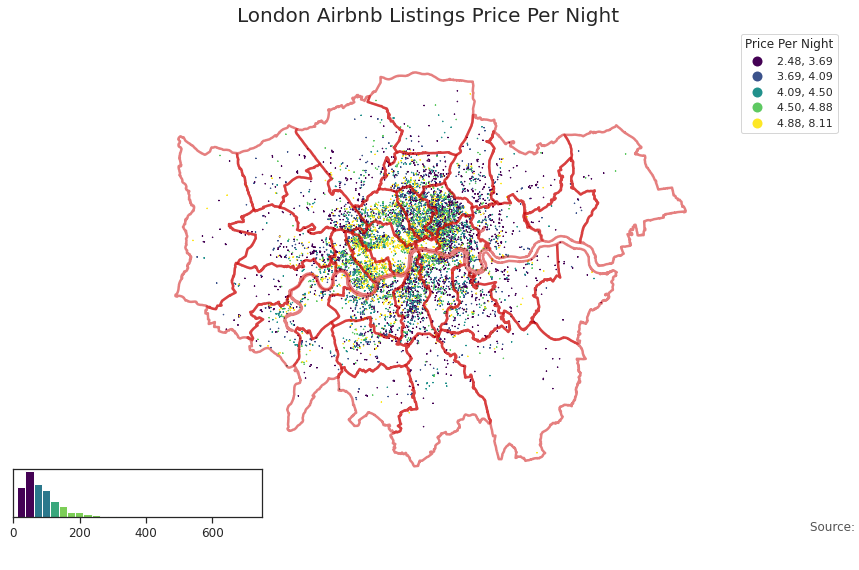

In [131]:
LondonMap()

# Compare with Original Data

In [132]:
cols = ['id','price','latitude','longitude']

url = 'https://github.com/jreades/i2p/raw/master/data/src/2020-08-24-listings.csv.gz?raw=true'

pdf = pd.read_csv(url, compression='gzip', low_memory=False,usecols=cols)

print(f"Data frame is {pdf.shape[0]:,} x {pdf.shape[1]}")

Data frame is 74,188 x 4


In [133]:
# replace $ sign and commas
pdf['price'] = pdf.price.str.replace('$','').str.replace(',','').astype('float')
pdf.drop(pdf[pdf.id.isna()].index.values, axis=0, inplace=True)
print(f"pdf now contains {pdf.shape[0]} rows.")
# geo-data are columns 'latitude' and 'longitude' 
pdf.drop(pdf[pdf.latitude.isna()].index.values, axis=0, inplace=True)
pdf.drop(pdf[pdf.longitude.isna()].index.values, axis=0, inplace=True)
print(f"pdf now contains {pdf.shape[0]} rows.")

pdf now contains 74186 rows.
pdf now contains 74184 rows.


/tmp/ipykernel_315/2787481189.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pdf['price'] = pdf.price.str.replace('$','').str.replace(',','').astype('float')


In [134]:
gdf1 = gpd.GeoDataFrame(pdf, 
      geometry=gpd.points_from_xy(pdf['longitude'], pdf['latitude'], crs='epsg:4326'))

print(f"gdf has {gdf1.shape[0]:,.0f} rows.")
gdf1.drop(gdf1[gdf1.price==0].index, axis=0, inplace=True) # no values price==0, this data set might not have errors in price
gdf1['lnprice'] = np.log(gdf1.price) 
print(f"gdf has {gdf1.shape[0]:,.0f} rows.")
print(f"The range of ln(price) is {gdf1.lnprice.min():,.2f} to {gdf1.lnprice.max():,.2f}")

gdf has 74,184 rows.
gdf has 74,178 rows.
The range of ln(price) is 1.95 to 9.83


<AxesSubplot:>

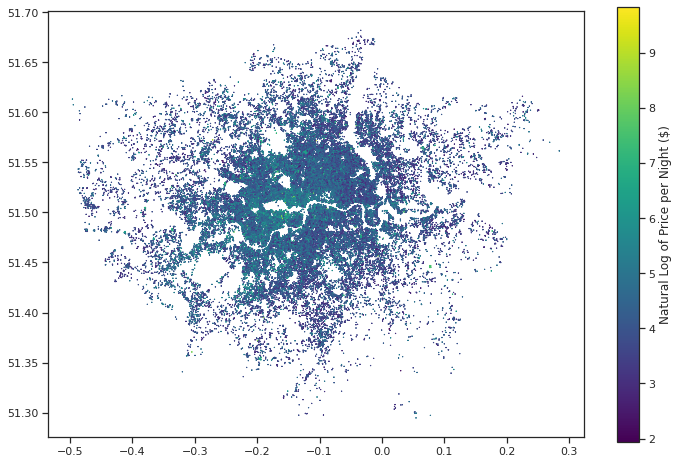

In [135]:
gdf1.plot(figsize=(12,8), marker='*', markersize=0.25, 
         column='lnprice', cmap='viridis',
         legend=True, legend_kwds={'label':'Natural Log of Price per Night ($)'})

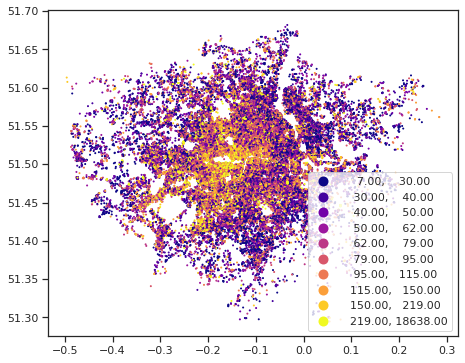

In [136]:
gdf1.plot(column='price', cmap='plasma', scheme='quantiles', k=10, markersize=1,legend=True, figsize=(8,6));

# Build Model

In [137]:
df1 = df[['host_is_superhost', 'price','host_listings_count', 'host_total_listings_count', 
          'latitude', 'longitude', 'bedrooms','beds','lnprice','room_type','bedrooms',
         'accommodates','minimum_nights','review_scores_rating', 'review_scores_cleanliness', 
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',  
        'instant_bookable', 'reviews_per_month','host_has_profile_pic','host_identity_verified','neighbourhood_cleansed']]
df1 = df1.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7865 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   host_is_superhost            7865 non-null   object  
 1   price                        7865 non-null   float64 
 2   host_listings_count          7865 non-null   int64   
 3   host_total_listings_count    7865 non-null   int64   
 4   latitude                     7865 non-null   float64 
 5   longitude                    7865 non-null   float64 
 6   bedrooms                     7865 non-null   float64 
 7   beds                         7865 non-null   float64 
 8   lnprice                      7865 non-null   float64 
 9   room_type                    7865 non-null   category
 10  bedrooms                     7865 non-null   float64 
 11  accommodates                 7865 non-null   int64   
 12  minimum_nights               7865 non-null   int64   
 13  rev

In [138]:
df1 = pd.get_dummies(df1)

In [139]:
# calculating VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(data, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        data_with_const = add_constant(data)

        vif_data = pd.Series([variance_inflation_factor(data_with_const.values, i) 
               for i in range(data_with_const.shape[1])], name= "VIF",
              index=data_with_const.columns).to_frame()

        # drop the const
        vif_data = vif_data.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_data.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_data.index[vif_data.VIF == vif_data.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            data = data.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return data

In [140]:
data_predictors_selected_VIF = drop_column_using_vif_(df1.drop('price', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(data_predictors_selected_VIF.columns)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping: host_listings_count
Dropping: bedrooms
Dropping: host_is_superhost_f
Dropping: room_type_Entire home/apt
Dropping: instant_bookable_f
Dropping: host_has_profile_pic_f
Dropping: host_identity_verified_f
Dropping: neighbourhood_cleansed_Barking and Dagenham
Dropping: neighbourhood_cleansed_Hackney
Dropping: longitude
Dropping: latitude
The columns remaining after VIF selection are:
Index(['host_total_listings_count', 'beds', 'lnprice', 'accommodates',
       'minimum_nights', 'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'reviews_per_month', 'host_is_superhost_t',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'instant_bookable_t', 'host_has_profile_pic_t',
       'host_identity_verified_t', 'neighbourhood_cleansed_Barnet',
       'neighbourhood_cleansed_Bexley', 'neighbourhood_cleansed_Brent',
       'neighbourhood_cleansed_Bromley', 

In [141]:
X = df1[['host_total_listings_count', 'accommodates', 'minimum_nights','beds','bedrooms',
       'room_type_Hotel room','room_type_Private room', 'room_type_Entire home/apt',
       'review_scores_rating', 'review_scores_cleanliness', 
       'review_scores_location', 'reviews_per_month', 'host_is_superhost_t','instant_bookable_t', 
       'host_identity_verified_t', 'neighbourhood_cleansed_Barnet',
       'neighbourhood_cleansed_Bexley', 'neighbourhood_cleansed_Brent',
       'neighbourhood_cleansed_Bromley', 'neighbourhood_cleansed_Camden',
       'neighbourhood_cleansed_City of London',
       'neighbourhood_cleansed_Croydon', 'neighbourhood_cleansed_Ealing',
       'neighbourhood_cleansed_Enfield', 'neighbourhood_cleansed_Greenwich',
       'neighbourhood_cleansed_Hammersmith and Fulham',
       'neighbourhood_cleansed_Haringey', 'neighbourhood_cleansed_Harrow',
       'neighbourhood_cleansed_Havering', 'neighbourhood_cleansed_Hillingdon',
       'neighbourhood_cleansed_Hounslow', 'neighbourhood_cleansed_Islington',
       'neighbourhood_cleansed_Kensington and Chelsea',
       'neighbourhood_cleansed_Kingston upon Thames',
       'neighbourhood_cleansed_Lambeth', 'neighbourhood_cleansed_Lewisham',
       'neighbourhood_cleansed_Merton', 'neighbourhood_cleansed_Newham',
       'neighbourhood_cleansed_Redbridge',
       'neighbourhood_cleansed_Richmond upon Thames',
       'neighbourhood_cleansed_Southwark', 'neighbourhood_cleansed_Sutton',
       'neighbourhood_cleansed_Tower Hamlets',
       'neighbourhood_cleansed_Waltham Forest',
       'neighbourhood_cleansed_Wandsworth',
       'neighbourhood_cleansed_Westminster']]
regression_model1 = sm.OLS(endog= df1['lnprice'], exog=sm.add_constant(X)).fit()
regression_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     371.1
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        23:22:45   Log-Likelihood:                -3743.8
No. Observations:                7865   AIC:                             7582.
Df Residuals:                    7818   BIC:                             7909.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             2.1188      0.098     21.647      0.000       1.927       2.311
host_total_listings_count                         0.0010      0.000      5.918      0.000       0.001       0.001
accommodates                                      0.1103      0.005     22.256      0.000       0.101       0.120
minimum_nights                                    0.0001      0.000      0.810      0.418      -0.000       0.000
beds                                             -0.0092      0.006     -1.504      0.133      -0.021       0.003
bedrooms                                          0.0690      0.005     13.496      0.000       0.059       0.079
bedrooms                                          0.0690      0.005     13.496      0.000       0.059       0.079
room_type_Hotel room                              1.1161      0.101     11.008      0.000       0.917       1.315
room_type_Private room                            0.3160      0.065      4.865      0.000       0.189       0.443
room_type_Entire home/apt                         0.8827      0.065     13.541      0.000       0.755       1.010
review_scores_rating                             -0.0017      0.001     -1.786      0.074      -0.004       0.000
review_scores_cleanliness                         0.0508      0.007      7.549      0.000       0.038       0.064
review_scores_location                            0.0734      0.007     10.349      0.000       0.060       0.087
reviews_per_month                                -0.0348      0.005     -6.638      0.000      -0.045      -0.025
host_is_superhost_t                               0.0366      0.011      3.269      0.001       0.015       0.059
instant_bookable_t                               -0.0338      0.012     -2.871      0.004      -0.057      -0.011
host_identity_verified_t                          0.0161      0.012      1.367      0.172      -0.007       0.039
neighbourhood_cleansed_Barnet                    -0.1371      0.038     -3.625      0.000      -0.211      -0.063
neighbourhood_cleansed_Bexley                    -0.0867      0.093     -0.928      0.354      -0.270       0.096
neighbourhood_cleansed_Brent                     -0.0019      0.030     -0.063      0.950      -0.060       0.057
neighbourhood_cleansed_Bromley                   -0.2717      0.055     -4.909      0.000      -0.380      -0.163
neighbourhood_cleansed_Camden                     0.2110      0.021      9.908      0.000       0.169       0.253
neighbourhood_cleansed_City of London             0.5930      0.077      7.748      0.000       0.443       0.743
neighbourhood_cleansed_Croydon                   -0.2859      0.054     -5.325      0.000      -0.391      -0.181
neigh

# Analysis for Room Type & Location

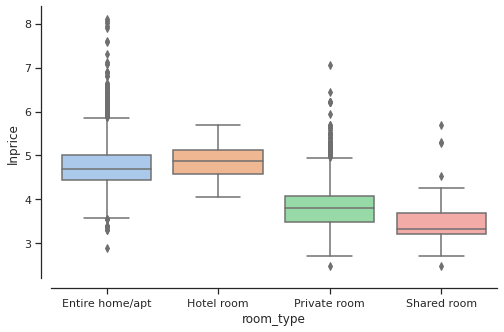

In [142]:
#lnprice transform
def boxplot():
    sns.set_style('whitegrid')
    sns.set_theme(style="ticks", palette="pastel")
    f,ax = plt.subplots(figsize=(8,5))
    sns.boxplot(y=df.lnprice, x=df.room_type)
    sns.despine(offset=10)
boxplot()    

In [143]:
df_neighbour = df.groupby(['neighbourhood_cleansed'])
print(type(df_neighbour))
df_neighbour.price.mean()

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


neighbourhood_cleansed
Barking and Dagenham       51.533333
Barnet                     61.134603
Bexley                    116.944444
Brent                      84.642533
Bromley                    62.618182
Camden                    121.304739
City of London            333.258065
Croydon                    49.695806
Ealing                     76.095508
Enfield                    64.476190
Greenwich                  68.651491
Hackney                    91.739934
Hammersmith and Fulham    108.559072
Haringey                   77.253026
Harrow                     57.272727
Havering                   56.250000
Hillingdon                 69.000000
Hounslow                   84.453048
Islington                  98.592204
Kensington and Chelsea    151.527416
Kingston upon Thames       86.506905
Lambeth                    83.228084
Lewisham                   74.550762
Merton                     88.003233
Newham                     69.273176
Redbridge                  48.865385
Richmond upon T

In [144]:
la_data = df.groupby(['neighbourhood_cleansed','room_type']).agg(
    {'price':['count','sum','mean','median','std',lambda x: x.quantile(0.25),lambda x: x.quantile(0.75)]}
).reset_index()
la_data.columns = la_data.columns.droplevel(0)
print(la_data.columns.values)
cols = la_data.columns.values
cols[ 0] = 'name'
cols[ 1] = 'room_type'
cols[-2] = 'lq'
cols[-1] = 'uq'
la_data.columns = cols

['' '' 'count' 'sum' 'mean' 'median' 'std' '<lambda_0>' '<lambda_1>']


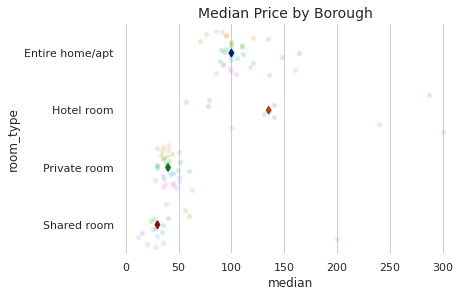

In [145]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

g = sns.stripplot(x="median", y="room_type", hue="name",
              data=la_data, dodge=True, alpha=.25, zorder=1)
g.legend_.remove()

# Show the median of medians
sns.pointplot(x="median", y="room_type",
              data=la_data.groupby('room_type').agg('median').reset_index(), 
              dodge=.232, join=False, palette="dark",
              markers="d", scale=.75, ci=None)

plt.gcf().subplots_adjust(top=0.92)
f.suptitle('Median Price by Borough', fontsize=14);

# Divided Borough by Part of London

In [146]:
import numpy as np
def mapping(b):
    if b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
        return 'Outer East and North East'
    elif  b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham','City of London']:
        return 'Inner East'
    elif  b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
        return 'Outer South'
    elif  b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden']:
        return 'Inner West'
    elif  b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet']:
        return 'Outer West and North West'
    else:
        return np.NaN


df['mapping'] = df['neighbourhood_cleansed'].apply(lambda x:mapping(x))

In [147]:
df2 = df[['host_is_superhost', 'price','host_listings_count', 'host_total_listings_count', 
          'latitude', 'longitude', 'bedrooms','beds','lnprice','room_type',
         'accommodates','minimum_nights','review_scores_rating', 'review_scores_cleanliness', 
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_accuracy', 
        'instant_bookable', 'reviews_per_month','host_has_profile_pic','host_identity_verified','mapping']]

In [148]:
df2 = df2.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df2 = pd.get_dummies(df2)

In [149]:
data_predictors_selected_VIF2 = drop_column_using_vif_(df2.drop('price', axis=1))
# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(data_predictors_selected_VIF2.columns)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping: host_listings_count
Dropping: host_is_superhost_f
Dropping: room_type_Entire home/apt
Dropping: instant_bookable_f
Dropping: host_has_profile_pic_f
Dropping: host_identity_verified_f
Dropping: mapping_Inner East
The columns remaining after VIF selection are:
Index(['host_total_listings_count', 'latitude', 'longitude', 'bedrooms',
       'beds', 'lnprice', 'accommodates', 'minimum_nights',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_accuracy', 'reviews_per_month',
       'host_is_superhost_t', 'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'instant_bookable_t', 'host_has_profile_pic_t',
       'host_identity_verified_t', 'mapping_Inner West',
       'mapping_Outer East and North East', 'mapping_Outer South',
       'mapping_Outer West and North West'],
      dtype='object')


In [150]:
X = df2[['host_total_listings_count', 'accommodates', 'minimum_nights','beds','bedrooms',
       'room_type_Hotel room','room_type_Private room', 'room_type_Entire home/apt',
       'review_scores_rating', 'review_scores_cleanliness', 
       'review_scores_location', 'reviews_per_month', 'host_is_superhost_t',
       'instant_bookable_t', 'host_has_profile_pic_t',
       'host_identity_verified_t', 'mapping_Inner West', 'mapping_Inner East',
       'mapping_Outer East and North East','mapping_Outer South']]
regression_model2 = sm.OLS(endog= df2['lnprice'], exog=sm.add_constant(X)).fit()
regression_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     781.4
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        23:23:00   Log-Likelihood:                -3987.4
No. Observations:                7865   AIC:                             8017.
Df Residuals:                    7844   BIC:                             8163.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 2.0454      0.139     14.665      0.000       1.772       2.319
host_total_listings_count             0.0010      0.000      6.009      0.000       0.001       0.001
accommodates                          0.1083      0.005     21.294      0.000       0.098       0.118
minimum_nights                        0.0003      0.000      1.563      0.118   -6.83e-05       0.001
beds                                 -0.0096      0.006     -1.517      0.129      -0.022       0.003
bedrooms                              0.1313      0.010     12.515      0.000       0.111       0.152
room_type_Hotel room                  1.0916      0.104     10.530      0.000       0.888       1.295
room_type_Private room                0.2937      0.067      4.408      0.000       0.163       0.424
room_type_Entire home/apt             0.8943      0.067     13.371      0.000       0.763       1.025
review_scores_rating                 -0.0034      0.001     -3.387      0.001      -0.005      -0.001
review_scores_cleanliness             0.0475      0.007      6.886      0.000       0.034       0.061
review_scores_location                0.0988      0.007     13.823      0.000       0.085       0.113
reviews_per_month                    -0.0291      0.005     -5.417      0.000      -0.040      -0.019
host_is_superhost_t                   0.0344      0.012      2.986      0.003       0.012       0.057
instant_bookable_t                   -0.0339      0.012     -2.806      0.005      -0.058      -0.010
host_has_profile_pic_t                0.0035      0.098      0.035      0.972      -0.188       0.195
host_identity_verified_t              0.0220      0.012      1.826      0.068      -0.002       0.046
mapping_Inner West                    0.2549      0.016     15.527      0.000       0.223       0.287
mapping_Inner East                    0.0407      0.015      2.634      0.008       0.010       0.071
mapping_Outer East and North East    -0.1731      0.025     -6.974      0.000      -0.222      -0.124
mapping_Outer South                  -0.0643      0.027     -2.377      0.017      -0.117      -0.011
==============================================================================
Omnibus:                     1905.820   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9745.132
Skew:                           1.073   Prob(JB):                         0.00
Kurtosis:                       8.013   Cond. No.                     3.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+03. This might indic

In [151]:
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet','City of London']:
    mapping[b]='Outer West and North West'
print(len(mapping.keys()))

33


In [152]:
la_data3 = df.set_index('neighbourhood_cleansed').groupby([mapping,'room_type']).agg(
    {'price':['mean','median']}
).reset_index()
la_data3.columns = la_data3.columns.droplevel(0)
cols = la_data3.columns.values
cols[0]  = 'area'
cols[1]  = 'room_type'
la_data3.columns = cols

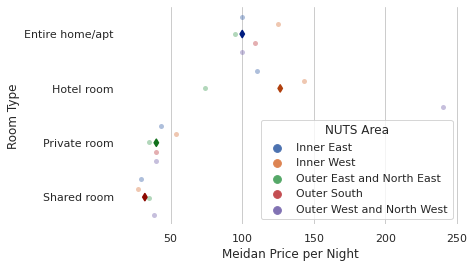

In [153]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

g = sns.stripplot(x="median", y="room_type", hue="area",
              data=la_data3, dodge=True, alpha=.45, zorder=1)
g.legend_.set_title('NUTS Area')

# Show the median of medians
sns.pointplot(x="median", y="room_type",
              data=la_data3.groupby('room_type').agg('median').reset_index(), 
              join=False, palette="dark",
              markers="d", scale=.75, ci=None)

# See if you can work out how to set the plot x- and y-labels...
plt.xlabel('Meidan Price per Night')
plt.ylabel('Room Type');

# Executive Briefing

## Executive summary
More and more investors are curious to invest in properties and let them on the Airbnb platform. However, it is vague and hard to identify which property is worth to invest. This research will quantify some factors using the data scraped from Airbnb by Inside Airbnb and aim to quantify them to release appropriate indications. This research will mainly focus on three macro factors, geographical location, property types and the landlord's situation to discuss what kind of properties are worth to invest.
1.	Background: An introduction to how renting on the Airbnb platform has developed today and why it is popular. The fact that more and more people are looking to invest through Airbnb. The reason why this paper uses a quantitative approach to the analysis of Airbnb data.
2.	Data Analysis: Introduce the research on the methods of how to approach quantify and conduct analysis steps by steps from macro to micro details. The impact of each of the macro factors and discover their details’ weight on the price.
3.	Conclusions and some feasible suggestions will be presented. Discuss some limitations and deficiencies of this research.
**Key findings:**
1.	From the geographical location factor perspective, in general, Inner London will be more expensive than Outer London, except in some rare cases like Richmond upon Thames. Especially, Kensington and Chelsea, Westminster and Camden have a higher positive impact on prices.
2.	From the property types perspective, Hotel room and Entire home/apartment are more likely to result in higher prices, with the Hotel room being the highest.
3.	From the landlords’ situation perspective, the property that landlord provided is cleaner, and the landlord are well managed and hospitable with high ratings will lead the price higher.

## Background
Nowadays, the house rental market is becoming more and more diverse and there are many ways to rent out the property for landlords. In traditionally there have been short-term and long-term rentals, but with the development of new technologies and some new concepts, the rise of the peer-to-peer (P2P) model has given landlords more options to rent their houses. The economy is developing into a networked economy instead of the traditional hierarchical structure (Oskam& Boswijk, 2016). Compare with the traditional way, the emerging P2P model has more advantages and is more flexible (Shabrina et al., 2017). The most rapid development of the P2P model is Airbnb (Lee & Kim, 2019), which gives landlords more ways to generate income and gives the property market a new lease of life. Moreover, with the proliferation of the sharing economy and peer-to-peer accommodation worldwide, more and more people prefer to rent properties on Airbnb rather than hotels or property agencies (Guttentag & Smith, 2017). Guests can also gain valuable local experiences through the sharing economy (Nica and Potcovaru, 2015). Specifically, in Asia, some of the properties are renovated for home parties and recreational activities with different kinds of entertainment facilities (Qiu et al., 2020).
Therefore, many people are looking at real estate and investing in it, creating all kinds of houses for rent on Airbnb, which can be called buy-to-let investment (Cocola-Gant& Gago, 2021). However, it is not a case of choosing a property blindly and investing in it. Before investing, investors need to investigate and site visits to ensure that the property they are investing in is profitable, considering some factors, such as the type of property, location (Chica-Olmo, González-Morales & Zafra-Gómez, 2020). These will influence the thinking of future hosts who wish to rent out their properties on Airbnb. Meanwhile, property owners increasingly rent out entire vacant flats permanently through Airbnb platforms (Sans & Domínguez, 2016). Thus, for some investors who want to invest in London property and rent it out on Airbnb, it is crucial to quantify and visualize data information that can help them where to invest better and predict the value of the house.


## Data Analysis

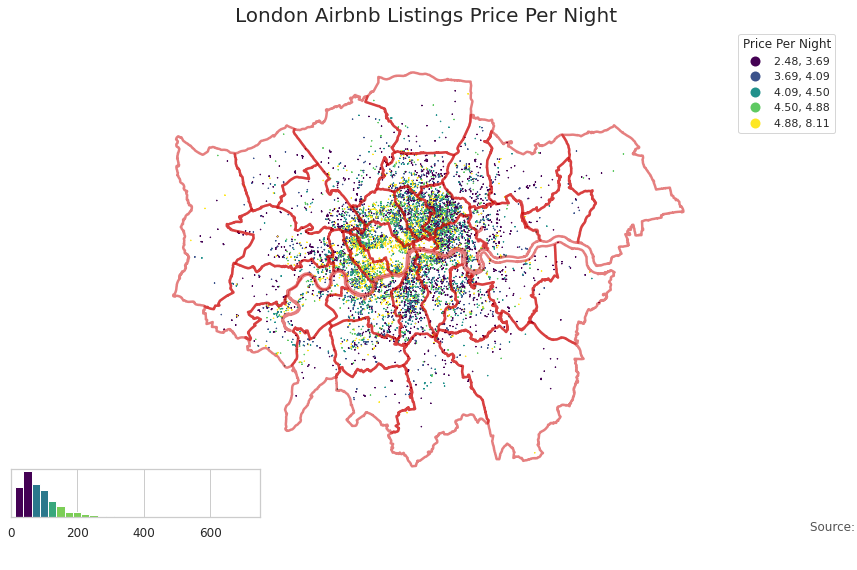

In [154]:
LondonMap()

Firstly, we observe the distribution of Airbnb prices per night in London after cleaning the data. Obviously, we can see that there is a strong correlation between the distribution of prices and the geographical location and seems the closer to the central part of the city, the higher the price per night of the house. Therefore, we introduce our assumption that prices are related to spatial distribution. Meanwhile, this paper assumes that the better of landlord's situation (represent good reputation) and the property types will lead to higher prices.

In [155]:
regression_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     371.1
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        23:23:02   Log-Likelihood:                -3743.8
No. Observations:                7865   AIC:                             7582.
Df Residuals:                    7818   BIC:                             7909.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             2.1188      0.098     21.647      0.000       1.927       2.311
host_total_listings_count                         0.0010      0.000      5.918      0.000       0.001       0.001
accommodates                                      0.1103      0.005     22.256      0.000       0.101       0.120
minimum_nights                                    0.0001      0.000      0.810      0.418      -0.000       0.000
beds                                             -0.0092      0.006     -1.504      0.133      -0.021       0.003
bedrooms                                          0.0690      0.005     13.496      0.000       0.059       0.079
bedrooms                                          0.0690      0.005     13.496      0.000       0.059       0.079
room_type_Hotel room                              1.1161      0.101     11.008      0.000       0.917       1.315
room_type_Private room                            0.3160      0.065      4.865      0.000       0.189       0.443
room_type_Entire home/apt                         0.8827      0.065     13.541      0.000       0.755       1.010
review_scores_rating                             -0.0017      0.001     -1.786      0.074      -0.004       0.000
review_scores_cleanliness                         0.0508      0.007      7.549      0.000       0.038       0.064
review_scores_location                            0.0734      0.007     10.349      0.000       0.060       0.087
reviews_per_month                                -0.0348      0.005     -6.638      0.000      -0.045      -0.025
host_is_superhost_t                               0.0366      0.011      3.269      0.001       0.015       0.059
instant_bookable_t                               -0.0338      0.012     -2.871      0.004      -0.057      -0.011
host_identity_verified_t                          0.0161      0.012      1.367      0.172      -0.007       0.039
neighbourhood_cleansed_Barnet                    -0.1371      0.038     -3.625      0.000      -0.211      -0.063
neighbourhood_cleansed_Bexley                    -0.0867      0.093     -0.928      0.354      -0.270       0.096
neighbourhood_cleansed_Brent                     -0.0019      0.030     -0.063      0.950      -0.060       0.057
neighbourhood_cleansed_Bromley                   -0.2717      0.055     -4.909      0.000      -0.380      -0.163
neighbourhood_cleansed_Camden                     0.2110      0.021      9.908      0.000       0.169       0.253
neighbourhood_cleansed_City of London             0.5930      0.077      7.748      0.000       0.443       0.743
neighbourhood_cleansed_Croydon                   -0.2859      0.054     -5.325      0.000      -0.391      -0.181
neigh

In addition to the geographical location indicators, we will also aim to analyse the factors influencing the price through the property types and the landlord's situation. After further manipulating the data, we treat some variables as dummy variables, to quantify them and build a linear regression model. Moreover, due to many variables, we use the VIF method to detect multicollinearity problems and obtain the final independent variables. Prior to building the final model, this study tried setting the price as the dependent variable, but the regression was not significant. Thus, we used a log-normal regression model with lnprice(the log transformation of price) as the dependent variable to make the model more appreciable.

In the results of this model, we found the R-squared of 0.686 and most of the coefficients are significant, indicating that our regression model is ideal. For property types, the better the room type, the higher the price, especially for hotel room which has the highest coefficient of 1.1192. Furthermore, as for the landlords’ situation, the coefficients on variables review_scores_cleanliness (the cleanliness situation of property), host_is_superhost (whether is a super host) etc. are all positive, indicating that the price of a property will increase if the house is clean, and the landlord is a super host and patient with the tenant. It is easy to comprehend this phenomenon, as guests prefer a comfortable living environment and suitable communication. If guests have a nice experience, they will post positive reviews and comments on Airbnb, and these will make the landlord’s home more desirable and thus more expensive.
Meanwhile, we explore that the price of a property is highly dependent on its location. For example, in Kensington and Chelsea, Camden and Westminster, the areas of Inner London, most of the coefficients are positive and large, indicating that houses in these areas will be rented at a higher price. Conversely, for areas such as Redbridge, Croydon and Ealing, as areas of Outer London, most of the coefficients are negative. However, in addition to most cases, we can find some areas of Outer London that also have positive coefficients, such as Richmond upon Thames, which is not in the city centre but is known for its traditional English idyllic lifestyle and is popular as a wealthy area leading to unconventional prices. Therefore, in general, there is a difference in prices between Inner and Outer London, we will observe this further and see how different they are.


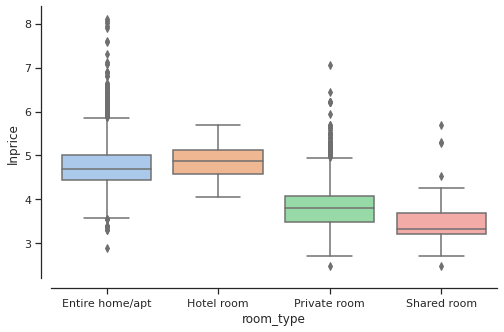

In [156]:
boxplot()

The boxplot shows the information of all room types, suggesting Entire home/apartment and Hotel room are the most popular to gain high rental profit.

In [157]:
regression_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lnprice   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     781.4
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        23:23:02   Log-Likelihood:                -3987.4
No. Observations:                7865   AIC:                             8017.
Df Residuals:                    7844   BIC:                             8163.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 2.0454      0.139     14.665      0.000       1.772       2.319
host_total_listings_count             0.0010      0.000      6.009      0.000       0.001       0.001
accommodates                          0.1083      0.005     21.294      0.000       0.098       0.118
minimum_nights                        0.0003      0.000      1.563      0.118   -6.83e-05       0.001
beds                                 -0.0096      0.006     -1.517      0.129      -0.022       0.003
bedrooms                              0.1313      0.010     12.515      0.000       0.111       0.152
room_type_Hotel room                  1.0916      0.104     10.530      0.000       0.888       1.295
room_type_Private room                0.2937      0.067      4.408      0.000       0.163       0.424
room_type_Entire home/apt             0.8943      0.067     13.371      0.000       0.763       1.025
review_scores_rating                 -0.0034      0.001     -3.387      0.001      -0.005      -0.001
review_scores_cleanliness             0.0475      0.007      6.886      0.000       0.034       0.061
review_scores_location                0.0988      0.007     13.823      0.000       0.085       0.113
reviews_per_month                    -0.0291      0.005     -5.417      0.000      -0.040      -0.019
host_is_superhost_t                   0.0344      0.012      2.986      0.003       0.012       0.057
instant_bookable_t                   -0.0339      0.012     -2.806      0.005      -0.058      -0.010
host_has_profile_pic_t                0.0035      0.098      0.035      0.972      -0.188       0.195
host_identity_verified_t              0.0220      0.012      1.826      0.068      -0.002       0.046
mapping_Inner West                    0.2549      0.016     15.527      0.000       0.223       0.287
mapping_Inner East                    0.0407      0.015      2.634      0.008       0.010       0.071
mapping_Outer East and North East    -0.1731      0.025     -6.974      0.000      -0.222      -0.124
mapping_Outer South                  -0.0643      0.027     -2.377      0.017      -0.117      -0.011
==============================================================================
Omnibus:                     1905.820   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9745.132
Skew:                           1.073   Prob(JB):                         0.00
Kurtosis:                       8.013   Cond. No.                     3.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+03. This might indic

In the second model, we sort the location variables and divide them into 5 parts to observe the regional impact. The R-squared of the model is 0.666, indicating that our model is still reliable. For the two main aspects of the property types and the landlord's situation, the conclusions are largely consistent with the previous model. We will mainly concentrate on the difference between Inner and Outer London. We can find that Inner London are all positive and Outer London are all negative, indicating that in general, investing in Inner London will result in higher rental prices. Furtherly, the Inner West has the highest coefficient of 0.2531 and this area will obtain the highest value. The -0.1734 for Outer east and Northeast shows that as an investor you may want to avoid this area as the rental effect of investing in this area will have a negative impact, resulting in reduced returns or even losses.

## Conclusion
Through prior research, we identify three main factors that impact rental prices: geographical location, property types and the landlord's situation and classify these three main factors into many variables. The outcomes of this study are broadly according to the assumptions. In general, we conclude and suggest if some investors want to invest in London property and rent it out on Airbnb, they should consider selecting Inner London as a priority, considering choosing the type of Entire home/apartment or Hotel room as the primary investment target. Moreover, landlords should keep the rooms clean and tidy, and the hosts themselves should be well managed and hospitable, providing as comfortable a stay as possible. Simultaneously, we find some outcomes and results contradicted assumptions. In the significant level variable instant_bookable shows the negative coefficient, which is contrary to our assumption. Moreover, we may explain that the properties are popular and have wide acclaim are difficult to book directly and normally they are needed to book in advance. Therefore, some of the remaining properties may not have high rating scores and good reviews leading it possible for immediate booking.
However, there are also some limitations of this study. Firstly, during cleaning the data process, because of many NaN values in the original data, we drop the data containing the NaN values directly, meaning the data we build the models are the subset of the entire dataset, which will lead to the models containing bias. Secondly, we find that there exist some extreme values leading the data are not following the normal distribution according to the JB-Test outcome. Leading this problem, one is the process of dropping the data may influence the outcomes. Another one is it may cause by the data itself because there are some incorrect data that exist in Inside Airbnb when they scraped from the Airbnb website (Alsudais, 2021). Therefore, in the following to extend this research we can do some transformations of data or use cook’s distance to exclude the extreme values.


# Bibliography

Alsudais, A., 2021. Incorrect data in the widely used Inside Airbnb dataset. Decision Support Systems, 141, pp.Decision Support Systems, 2021–02, Vol.141.

Chica-Olmo, J., González-Morales, J.G. & Zafra-Gómez, J.L., 2020. Effects of location on Airbnb apartment pricing in Málaga. Tourism management (1982), 77, p.103981.

Cocola-Gant, A. & Gago, A., 2021. Airbnb, buy-to-let investment and tourism-driven displacement: A case study in Lisbon. Environment and planning. A, 53(7), pp.1671–1688.

Guttentag, D.A. & Smith, S.L.J., 2017. Assessing Airbnb as a disruptive innovation relative to hotels: Substitution and comparative performance expectations. International journal of hospitality management, 64, pp.1–10.

Lee, K.-H. & Kim, D.H., 2019. A peer-to-peer (P2P) platform business model: the case of Airbnb. Service business, 13(4), pp.647–669.

Nica, E. & Potcovaru, A. 2015, "THE SOCIAL SUSTAINABILITY OF THE SHARING ECONOMY", Economics, Management and Financial Markets, vol. 10, no. 4, pp. 69-75.

Oskam, J. & Boswijk, A., 2016. Airbnb: the future of networked hospitality businesses. Journal of tourism futures, 2(1), pp.22–42.

Qiu, D. et al., 2020. The future of Airbnb in China: industry perspective from hospitality leaders. Tourism review (Association internationale d'experts scientifiques du tourisme), 75(4), pp.609–624.

Sans, A.A. & Domínguez, A.Q., 2016. Unravelling airbnb: Urban perspectives from Barcelona. In Reinventing the Local in Tourism: Producing, Consuming and Negotiating Place. pp. 209–228.

Shabrina, Z. et al., 2017. Beyond informality: The rise of peer-to-peer (P2P) renting, pp.(CASA Working Paper 209). The Bartlett Centre for Advanced Spatial Analysis, UCL (University College London): London, UK. (2017).
